In [3]:
import numpy as np
import random
from utils import *
from train import train_2l,train_3l,train_1
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
def get_training_adj_lists(labels, adj_lists,seed):
    np.random.seed(seed)
    random.seed(seed)
    num_nodes = labels.shape[0]
    rand_indices = np.random.permutation(num_nodes)
    train = rand_indices[:int(num_nodes*0.6)]
    valid = rand_indices[int(num_nodes*0.6):int(num_nodes*0.8)]
    test = (rand_indices[int(num_nodes*0.8):])    
    train_and_valid = rand_indices[:int(num_nodes*0.8)]
    
    adj_lists_train = defaultdict(set)
    adj_lists_valid = defaultdict(set)
    for key in adj_lists:
        if key in train:
            nodes = []
            for node in adj_lists[key]:
                if node in train:
                    nodes.append(node)
            nodes = set(nodes)
            adj_lists_train[key] = nodes
    for key in adj_lists:
        if key in train_and_valid:
            nodes = []
            for node in adj_lists[key]:
                if node in train_and_valid:
                    nodes.append(node)
            nodes = set(nodes)
            adj_lists_valid[key] = nodes
    return adj_lists_train,adj_lists_valid,train,valid,test

In [5]:
def shuffle_edges(dict_edges,n_swap,n_try):
    G_ = nx.Graph(dict_edges)
    num_edges = nx.number_of_edges(G_)
    print(num_edges)
    print(num_edges*n_swap)
    G_swap = nx.double_edge_swap(G_,int(n_swap*num_edges),n_try*int(n_swap*num_edges))
    edge_list = list(nx.to_edgelist(G_swap))
    adj_lists = defaultdict(set)
    for i in range(len(edge_list)):
        adj_lists[edge_list[i][0]].add(edge_list[i][1])
        adj_lists[edge_list[i][1]].add(edge_list[i][0])    
    return adj_lists

In [11]:
def shuffle_edges(adj_l,n_swap,n_try):
    G_ = nx.Graph(adj_l)
    num_edges = nx.number_of_edges(G_)
    print(num_edges)
    print(num_edges*n_swap)
    print(nx.number_of_nodes(G_))
    G_swap = nx.double_edge_swap(G_,int(n_swap*num_edges),n_try*int(n_swap*num_edges))
    edge_list = list(nx.to_edgelist(G_swap))
    adj_lists = defaultdict(set)
    for i in range(len(edge_list)):
        adj_lists[edge_list[i][0]].add(edge_list[i][1])
        adj_lists[edge_list[i][1]].add(edge_list[i][0])    
    for i in list(set(list(G_.nodes()))-set(list(adj_lists.keys()))):
        print(i)
        adj_lists[i] = set()
    return adj_lists

In [7]:
feat_data,labels,full_adjs = load_data('citeseer',path='/home/zhihao/Document/gnn_fd/graphSage/data/')

In [12]:
full_adjs_shuffle = shuffle_edges(full_adjs,0.05,10)

4600
230.0
3327


In [16]:

results_mlp = []
    
for seed in range(10):
    import torch
    from torch import nn
    from torch.nn import ReLU
    
    from torch.autograd import Variable
    from sklearn.metrics import f1_score,accuracy_score
    import glob
    import os
    import time
    batch_size = 128
    t_total = time.time()
    loss_values = []
    loss_train = []
    bad_counter = 0
    epochs = 70
    best = epochs + 1
    best_epoch = 0   
    temp_path = './citeseer/'
    patience = 5
    num_class = 6
    hidden_num = 128
    lr = 0.0002
    #results = []
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    class MLPModel(nn.Module):
        def __init__(self,num_classes,hidden_dim,feature_dim):
            super(MLPModel,self).__init__()
            self.hidden = nn.Linear(feature_dim,hidden_dim)
            self.layer = nn.Linear(hidden_dim,num_classes)
            self.xent = nn.CrossEntropyLoss()
            self.act1 = ReLU()
        def forward(self,nodes):
            X = self.hidden(nodes)
            X = self.act1(X)
            scores = self.layer(X)
            return scores
        def loss(self,nodes,labels):
            scores = self.forward(nodes)
            return self.xent(scores,labels.squeeze())
        
    mlp = MLPModel(num_class,hidden_num,feat_data.shape[1] )
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mlp.parameters()), lr=lr)
    
    
    for epoch in range(epochs):
        random.shuffle(training)
        num_batches = int(len(training) / batch_size) + 1
        train_losses = []
        start_time = time.time()
        for batch in range(num_batches):   
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(training))
            batch_nodes = training[i_start:i_end]
            
            optimizer.zero_grad()
            loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            train_losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
    
        
        num_batches_valid = int(len(validation) / batch_size) 
        valid_losses = []
        for batch in range(num_batches_valid):
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(validation))
            batch_nodes = validation[i_start:i_end]
    
            loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            valid_losses.append(loss.data.item())
  
        
        loss_train.append(np.average(train_losses))
        loss_values.append(np.average(valid_losses))
        torch.save(mlp.state_dict(),temp_path+'{}.pkl'.format(epoch))
        if loss_values[-1] < best:
            best = loss_values[-1]
            best_epoch = epoch 
            bad_counter = 0
        else:
            bad_counter += 1
        if bad_counter == patience:
            break
        files = glob.glob(temp_path+'*.pkl')
        for file in files:
            epoch_nb = int(file[len(temp_path):].split('.')[0])
            if epoch_nb < best_epoch:
                os.remove(file)
    files = glob.glob(temp_path+'*.pkl')
    for file in files:
        epoch_nb = int(file[len(temp_path):].split('.')[0])
        if epoch_nb > best_epoch:
            os.remove(file)

    mlp.load_state_dict(torch.load(temp_path+'{}.pkl'.format(best_epoch)))        
    print(best_epoch)
    
    num_batches_test = int(len(testing) / batch_size) 
    test_outputs = []
    test_labels = []
    for batch in range(num_batches_test):
        i_start = batch * batch_size
        i_end = (batch + 1) * batch_size
        batch_nodes = testing[i_start:i_end]
        test_output = torch.zeros(batch_size,num_class)
        for i in range(3):
            test_output = test_output + mlp.forward(torch.Tensor(feat_data[np.array(batch_nodes)]))
        
        test_outputs.extend(list(test_output.data.cpu().numpy().argmax(axis=1)))
        test_labels.extend(list(labels[batch_nodes]))
        
    accuracy_score(test_labels,test_outputs)
    results_mlp.append([loss_train,loss_values,accuracy_score(test_labels,test_outputs)])

29
30
30
28
27
28
28
31
31
28


In [48]:
results_sagegcn_0 = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
    
    new_adjs = {}
    for key in full_adjs_shuffle:
        neighbs_set = full_adjs_shuffle[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs_shuffle[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    
    results_sagegcn_0.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,70,5,6,'./citeseer/',hidden=128,lr=0.0002,batch_size=128))



In [76]:
ratio_list = [x*0.05 for x in range(11)]
results_0 = []
num = 10
for ratio in ratio_list:
    full_adjs_shuffle = shuffle_edges(full_adjs,ratio,10)
    results_sagegcn_0 = []
    for seed in range(num):
        training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
        
        new_adjs = {}
        for key in full_adjs_shuffle:
            neighbs_set = full_adjs_shuffle[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(full_adjs_shuffle[node] & neighbs_set)
            new_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_adjs[key].add((node,n_list.count(node)))
        new_training_adjs = {}
        for key in training_adjs:
            neighbs_set = training_adjs[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(training_adjs[node] & neighbs_set)
            new_training_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_training_adjs[key].add((node,n_list.count(node)))
        
        results_sagegcn_0.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,70,5,6,'./citeseer/',hidden=128,lr=0.0002,batch_size=128))
    result_0 = []
    for i in range(num):
        result_0.append(results_sagegcn_0[i][2])
    results_0.append(result_0)



4600
0.0
4600
230.0
4600
460.0
4600
690.0000000000001
4600
920.0
4600
1150.0
4600
1380.0000000000002
4600
1610.0000000000002
4600
1840.0
4600
2070.0
4600
2300.0


In [50]:
results_sagegcn_08 = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
    
    new_adjs = {}
    for key in full_adjs_shuffle:
        neighbs_set = full_adjs_shuffle[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs_shuffle[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    
    results_sagegcn_08.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.8,70,5,6,'./citeseer/',hidden=128,lr=0.0005,batch_size=128)
)


In [51]:
result_08 = []
for i in range(10):
    result_08.append(results_sagegcn_08[i][2])
sum(result_08)/10

0.7390625000000001

In [32]:
result_08 = [0.7640625,
 0.7671875,
 0.778125,
 0.7875,
 0.7625,
 0.7625,
 0.7796875,
 0.775,
 0.7546875,
 0.759375]
sum(result_08)

7.690625000000001

In [21]:
results_sagegcn_best = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
    res = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,6,'./citeseer/',hidden=128,lr=0.0002,batch_size=128)   
    for i in range(1,11):
        temp = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.2*i,100,5,6,'./citeseer/',hidden=128,lr=0.0002,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    
    results_sagegcn_best.append(res)





In [ ]:
ratio_list = [x*0.05 for x in range(11)]
results_best = []
results_best_r = []
num = 10
for ratio in ratio_list:
    full_adjs_shuffle = shuffle_edges(full_adjs,ratio,10)
    results_sagegcn_best = []
    results_sagegcn_best_r = []
    for seed in range(num):
        training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
        
        new_adjs = {}
        for key in full_adjs_shuffle:
            neighbs_set = full_adjs_shuffle[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(full_adjs_shuffle[node] & neighbs_set)
            new_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_adjs[key].add((node,n_list.count(node)))
        new_training_adjs = {}
        for key in training_adjs:
            neighbs_set = training_adjs[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(training_adjs[node] & neighbs_set)
            new_training_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_training_adjs[key].add((node,n_list.count(node)))
        res = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,6,'./citeseer/',hidden=128,lr=0.0002,batch_size=128)   
        r = 0
        for i in range(1,11):
            temp = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.2*i,100,5,6,'./citeseer/',hidden=128,lr=0.0002,batch_size=128)
            if res[2] < temp[2]:
                res = temp   
                r = i * 0.2
        results_sagegcn_best.append(res)
        results_sagegcn_best_r.append(r)
    
    result_best = []
    for i in range(num):
        result_best.append(results_sagegcn_best[i][2])
    results_best.append(result_best)
    results_best_r.append(results_sagegcn_best_r)



4600
0.0
4600
230.0


In [ ]:
import pickle
def save_list(path,list_):
    file = open(path,'wb')
    pickle.dump(list_,file)
    file.close()

In [24]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/mlp.pkl',results_mlp)

In [79]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/sage_0_randomedge.pkl',results_0)

In [80]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/sage_best_randomedge.pkl',results_best)

In [ ]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/sage_best_randomedge_r.pkl',results_best_r)

In [1]:
results_best_r

NameError: name 'results_best_r' is not defined

In [87]:
for i in range(len(results_0)):
    print(sum(results_0[i])/10)

0.7634375
0.7364062500000002
0.70890625
0.69765625
0.6751562499999999
0.6587500000000001
0.63203125
0.6078125000000001
0.60203125
0.5843750000000001
0.5721874999999998


In [88]:
for i in range(len(results_best)):
    print(sum(results_best[i])/10)

0.77734375
0.7682812500000001
0.7628125000000001
0.7617187499999999
0.7579687500000001
0.750625
0.74625
0.7446875
0.74375
0.743125
0.7459374999999999


training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,0)

In [37]:
batch_size = 128
t_total = time.time()
loss_values = []
loss_train = []
bad_counter = 0
epochs = 100
best = epochs + 1
best_epoch = 0   
temp_path = './citeseer/'
patience = 100
num_class = 6
hidden_num = 128
lr = 0.0001

mlp = MLPModel(num_class,hidden_num,feat_data.shape[1] )
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mlp.parameters()), lr=lr)


for epoch in range(epochs):
    random.shuffle(training)
    num_batches = int(len(training) / batch_size) + 1
    train_losses = []
    start_time = time.time()
    for batch in range(num_batches):   
        i_start = batch * batch_size
        i_end = min((batch + 1) * batch_size, len(training))
        batch_nodes = training[i_start:i_end]
        
        optimizer.zero_grad()
        loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
        
        train_losses.append(loss.data.item())
        loss.backward()
        optimizer.step()

    
    num_batches_valid = int(len(validation) / batch_size) 
    valid_losses = []
    for batch in range(num_batches_valid):
        i_start = batch * batch_size
        i_end = min((batch + 1) * batch_size, len(validation))
        batch_nodes = validation[i_start:i_end]

        loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
        
        valid_losses.append(loss.data.item())

    
    loss_train.append(np.average(train_losses))
    loss_values.append(np.average(valid_losses))
    torch.save(mlp.state_dict(),temp_path+'{}.pkl'.format(epoch))
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch 
        bad_counter = 0
    else:
        bad_counter += 1
    if bad_counter == patience:
        break
    files = glob.glob(temp_path+'*.pkl')
    for file in files:
        epoch_nb = int(file[len(temp_path):].split('.')[0])
        if epoch_nb < best_epoch:
            os.remove(file)
files = glob.glob(temp_path+'*.pkl')
for file in files:
    epoch_nb = int(file[len(temp_path):].split('.')[0])
    if epoch_nb > best_epoch:
        os.remove(file)
mlp.load_state_dict(torch.load(temp_path+'{}.pkl'.format(best_epoch)))        
print(best_epoch)

num_batches_test = int(len(testing) / batch_size) 
test_outputs = []
test_labels = []
for batch in range(num_batches_test):
    i_start = batch * batch_size
    i_end = (batch + 1) * batch_size
    batch_nodes = testing[i_start:i_end]
    test_output = torch.zeros(batch_size,num_class)
    for i in range(3):
        test_output = test_output + mlp.forward(torch.Tensor(feat_data[np.array(batch_nodes)]))
    test_outputs.extend(list(test_output.data.cpu().numpy().argmax(axis=1)))
    test_labels.extend(list(labels[batch_nodes]))
    
loss_mlp = [loss_train,loss_values]

59


In [97]:
    #new_adjs = {}
    #for key in full_adjs:
    #    neighbs_set = full_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(full_adjs[node] & neighbs_set)
    #    new_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_adjs[key].add((node,n_list.count(node)))
    #new_training_adjs = {}
    #for key in training_adjs:
    #    neighbs_set = training_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(training_adjs[node] & neighbs_set)
    #    new_training_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_training_adjs[key].add((node,n_list.count(node)))
    
    loss_sage = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,100,6,'./citeseer/',hidden=128,lr=0.0001,batch_size=128)

In [95]:
    #new_adjs = {}
    #for key in full_adjs:
    #    neighbs_set = full_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(full_adjs[node] & neighbs_set)
    #    new_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_adjs[key].add((node,n_list.count(node)))
    #new_training_adjs = {}
    #for key in training_adjs:
    #    neighbs_set = training_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(training_adjs[node] & neighbs_set)
    #    new_training_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_training_adjs[key].add((node,n_list.count(node)))
    
    loss_ncgnn = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,1.2,100,100,6,'./citeseer/',hidden=128,lr=0.0001,batch_size=128)

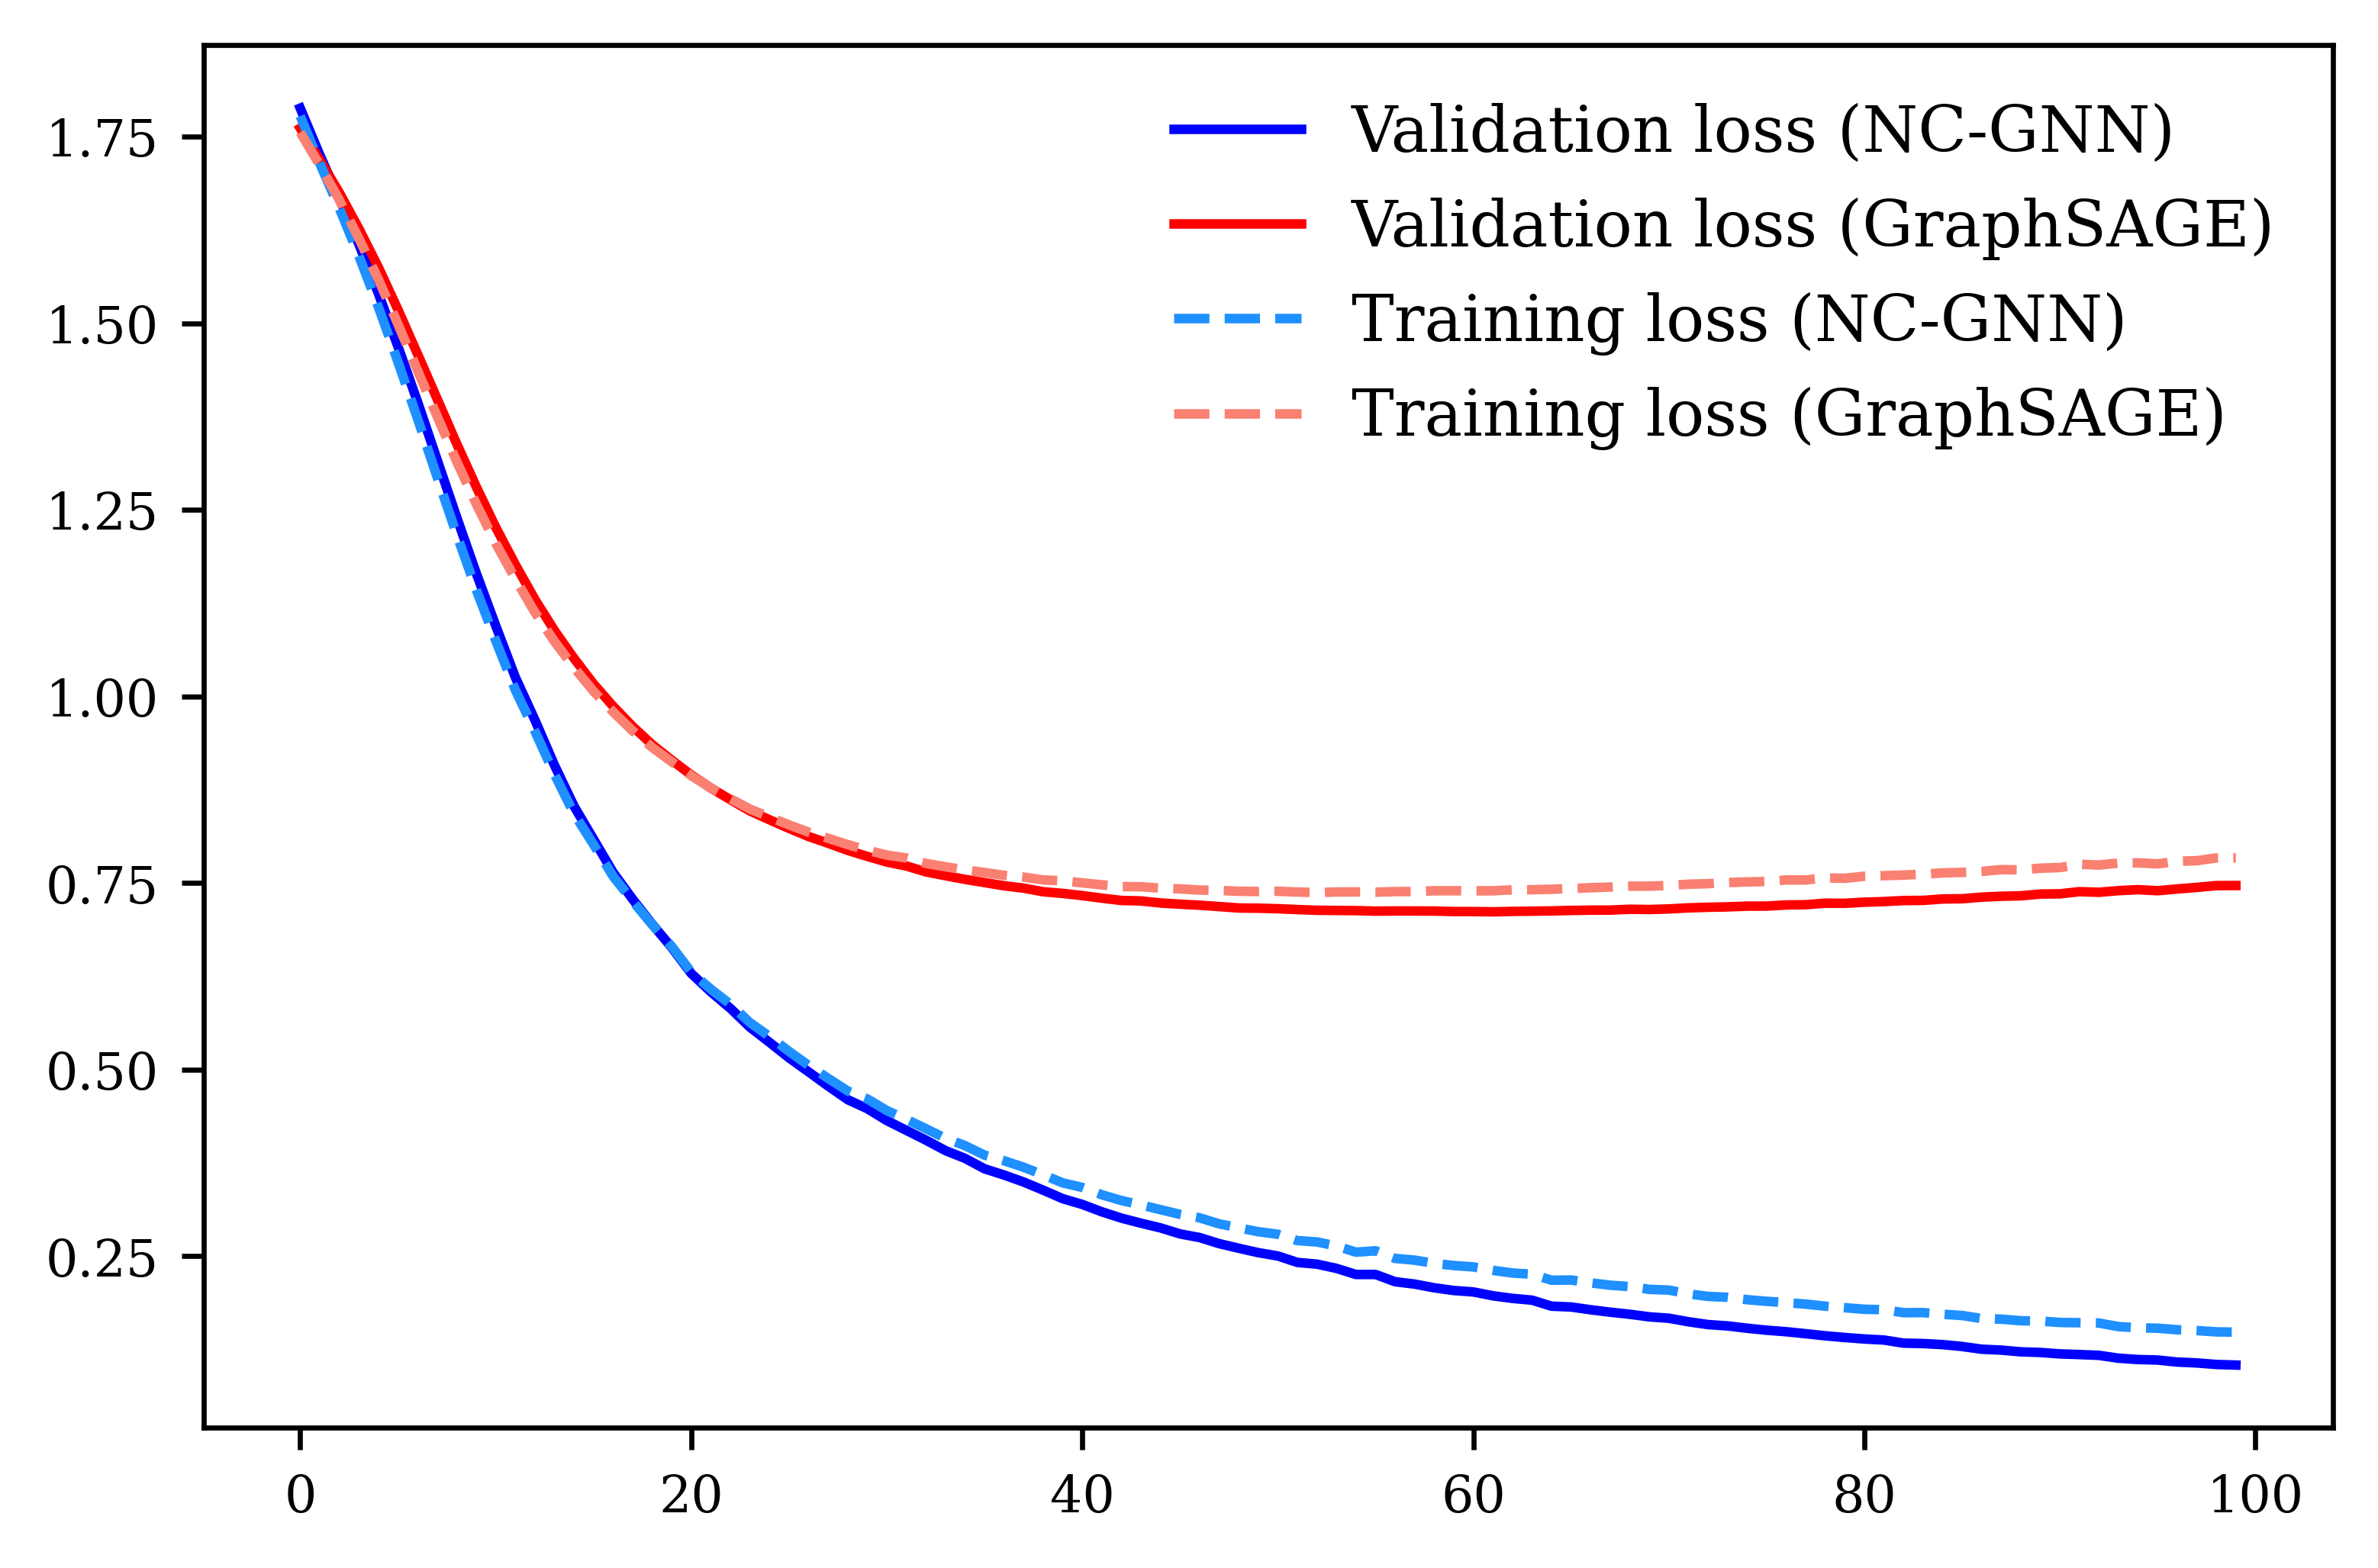

In [61]:
import matplotlib.pyplot as plt
with plt.style.context(['ieee']): 
    fig, ax = plt.subplots(figsize=(6,4))

    ax.plot(loss_ncgnn[0],'-',color='b',label='Validation loss (NC-GNN)')
    ax.plot(loss_ncgnn[1],'-',color='r',label='Validation loss (GraphSAGE)')
    ax.plot(loss_sage[0],'--',color='dodgerblue',label='Training loss (NC-GNN)')
    ax.plot(loss_sage[1],'--',color='salmon',label='Training loss (GraphSAGE)')
    ax.legend(fontsize=10,loc=1,frameon=False)

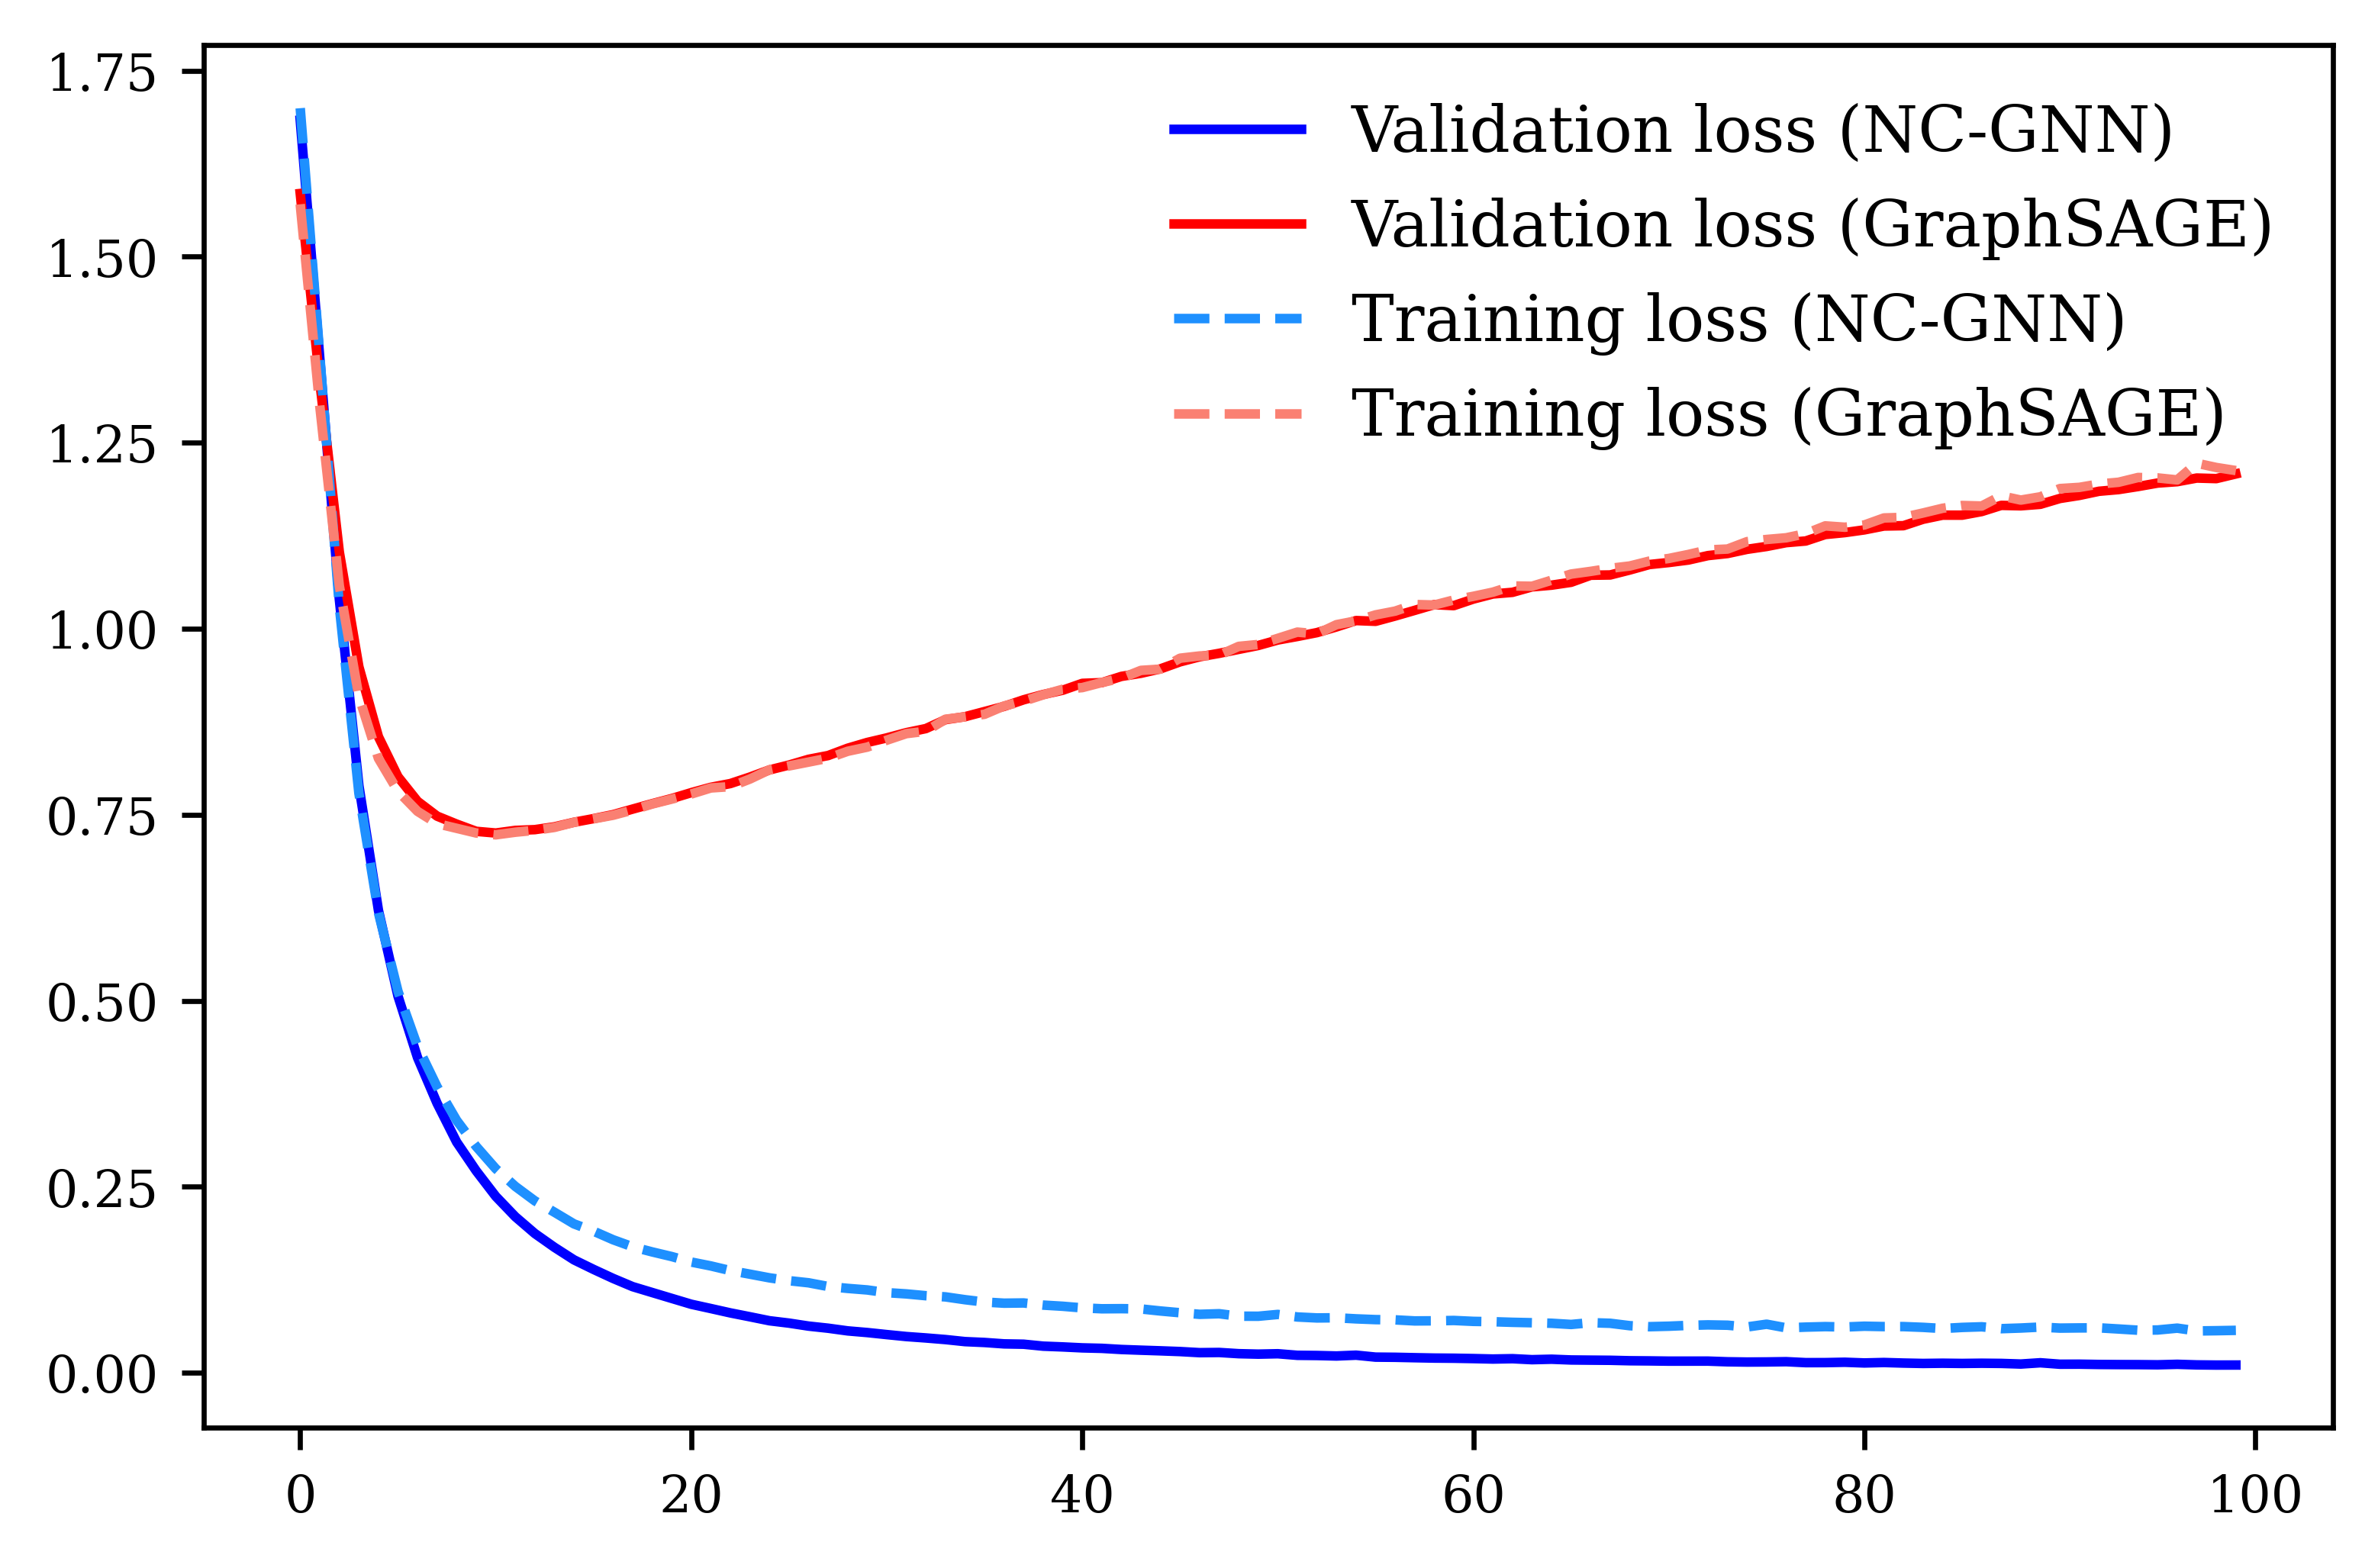

In [98]:
import matplotlib.pyplot as plt
with plt.style.context(['ieee']): 
    fig, ax = plt.subplots(figsize=(6,4))

    ax.plot(loss_ncgnn[0],'-',color='b',label='Validation loss (NC-GNN)')
    ax.plot(loss_ncgnn[1],'-',color='r',label='Validation loss (GraphSAGE)')
    ax.plot(loss_sage[0],'--',color='dodgerblue',label='Training loss (NC-GNN)')
    ax.plot(loss_sage[1],'--',color='salmon',label='Training loss (GraphSAGE)')
    ax.legend(fontsize=10,loc=1,frameon=False)

In [59]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/loss.pkl',[loss_mlp,loss_sage,loss_ncgnn])

In [33]:
training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,1)

In [45]:
    acc_lists = []    
    #new_adjs = {}
    #for key in full_adjs:
    #    neighbs_set = full_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(full_adjs[node] & neighbs_set)
    #    new_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_adjs[key].add((node,n_list.count(node)))
    #new_training_adjs = {}
    #for key in training_adjs:
    #    neighbs_set = training_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(training_adjs[node] & neighbs_set)
    #    new_training_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_training_adjs[key].add((node,n_list.count(node)))
            
    #res = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)   
    for j in range(20):
        acc_list = []
        for i in range(0,11):
            acc_list.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.3*i,100,10,6,'./citeseer/',hidden=128,lr=0.0003,batch_size=128)[2])
        acc_lists.append(acc_list)

In [46]:
acc_array = np.array(acc_lists)

In [47]:
import matplotlib.pyplot as plt

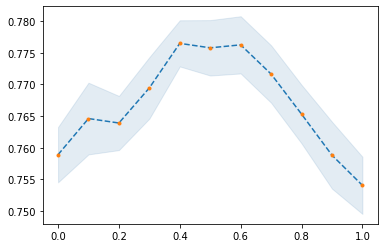

In [43]:
plt.plot([i*0.1 for i in range(11)],np.mean(acc_array,axis=0),'--')
plt.plot([i*0.1 for i in range(11)],np.mean(acc_array,axis=0),'.')
plt.fill_between([i*0.1 for i in range(11)],np.mean(acc_array,axis=0)-np.std(acc_array,axis=0),np.mean(acc_array,axis=0)+np.std(acc_array,axis=0),color='steelblue',alpha=0.15)


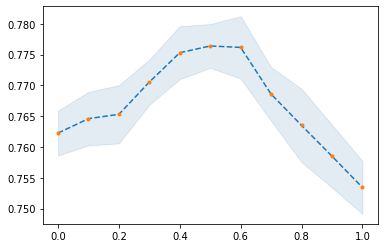

In [48]:
plt.plot([i*0.1 for i in range(11)],np.mean(acc_array,axis=0),'--')
plt.plot([i*0.1 for i in range(11)],np.mean(acc_array,axis=0),'.')
plt.fill_between([i*0.1 for i in range(11)],np.mean(acc_array,axis=0)-np.std(acc_array,axis=0),np.mean(acc_array,axis=0)+np.std(acc_array,axis=0),color='steelblue',alpha=0.15)


In [49]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/acc_array_20.pkl',acc_array)

# Concatenation

In [6]:
cancat_results_sagegcn_0_1 = []
cancat_results_sagegcn_0_2l = []
cancat_results_sagegcn_0_3l = []

for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    cancat_results_sagegcn_0_1.append(train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,6,'./citeseer/',hidden=128,lr=0.0003,batch_size=128))        
    cancat_results_sagegcn_0_2l.append(train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,6,'./citeseer/',hidden=128,lr=0.0003,batch_size=128))
    cancat_results_sagegcn_0_3l.append(train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,6,'./citeseer/',hidden=128,lr=0.0003,batch_size=128))



In [16]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/concat/sage_0_1.pkl',cancat_results_sagegcn_0_1)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/concat/sage_0_2l.pkl',cancat_results_sagegcn_0_2l)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/concat/sage_0_3l.pkl',cancat_results_sagegcn_0_3l)

In [12]:
a = []
for i in cancat_results_sagegcn_0_1:
    a.append(i[2])
sum(a)

7.7093750000000005

In [13]:
a = []
for i in cancat_results_sagegcn_0_2l:
    a.append(i[2])
sum(a)

7.69375

In [14]:
a=[]
for i in cancat_results_sagegcn_0_3l:
    a.append(i[2])
sum(a)

7.6234375

In [15]:
cancat_results_sagegcn_best_1 = []
cancat_results_sagegcn_best_2l = []
cancat_results_sagegcn_best_3l = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
    res = train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,6,'./citeseer/',hidden=128,lr=0.0003,batch_size=128)   
    for i in range(1,11):
        temp = train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0.3*i,500,5,6,'./citeseer/',hidden=128,lr=0.0003,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    cancat_results_sagegcn_best_1.append(res)
    
    res = train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,6,'./citeseer/',hidden=128,lr=0.0003,batch_size=128)   
    for i in range(1,11):
        temp = train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0.3*i,500,5,6,'./citeseer/',hidden=128,lr=0.0003,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    cancat_results_sagegcn_best_2l.append(res)
    
    res = train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,6,'./citeseer/',hidden=128,lr=0.0003,batch_size=128)   
    for i in range(1,11):
        temp = train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0.3*i,500,5,6,'./citeseer/',hidden=128,lr=0.0003,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    cancat_results_sagegcn_best_3l.append(res)


In [17]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/concat/sage_best_1.pkl',cancat_results_sagegcn_best_1)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/concat/sage_best_2l.pkl',cancat_results_sagegcn_best_2l)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/citeseer/concat/sage_best_3l.pkl',cancat_results_sagegcn_best_3l)

In [18]:
a = []
for i in cancat_results_sagegcn_best_1:
    a.append(i[2])
sum(a)

7.793749999999999

In [19]:
a = []
for i in cancat_results_sagegcn_best_2l:
    a.append(i[2])
sum(a)

7.7906249999999995

In [20]:
a = []
for i in cancat_results_sagegcn_best_3l:
    a.append(i[2])
sum(a)

7.746874999999999

# structure analysis

In [40]:
import networkx as nx

In [50]:
G_ = nx.Graph(full_adjs)

In [51]:
G_.number_of_edges()

4600

In [53]:
G_.number_of_nodes()

3327

In [52]:
len(full_adjs)

3327

In [55]:
nx.connected_components(G_)

<generator object connected_components at 0x7fb280a15350>

In [56]:
[len(c) for c in sorted(nx.connected_components(G_), key=len, reverse=True)]

[2120,
 18,
 17,
 15,
 13,
 12,
 12,
 11,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
